## Imports and Path/Variable Definitions

In [51]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import h5py
from scipy import signal
import argparse
import seaborn as sns
from datetime import date
import os
import X_gnss_unet_datagen_fn22 # Module with CNN/data generator code

sns.set_style('white')

project_name = 'july6' # Based on the name of the FakeQuakes project
fq_dir = '/hdd/rc_fq/summer23/' # Where are the FakeQuakes stored? (The final .hdf5 file)
noise_dir = '/home/sdybing/gnss-picker/data/noisedata/' # Where is the noise data stored?
realdata_dir = '/home/sdybing/gnss-picker/data/realdata/summer23/' # Where is the real data stored?

cnn_save_dir = '/home/sdybing/gnss-picker/cnn_models_outputs/' # Where do you want to save this code's outputs?
project_save_dir = cnn_save_dir + project_name + '_fq_train/'
base_figure_save_dir = project_save_dir + 'base_data_figures/' # Where to save the figures of just the data/generator tests
models_path = project_save_dir + 'models/'
if os.path.isdir(project_save_dir):
    pass
else:
    os.makedirs(project_save_dir)
    os.makedirs(base_figure_save_dir)
    os.makedirs(models_path)
    
train = False # Do you want to train?
drop = 1 # Drop?
resume = 0 # Resume training
large = 0.5 # Large unet
fac = large
epochs = 100 # How many epochs?
std = 3 # How long do you want the Gaussian STD to be?
sr = 1 # Sample rate (Hz)
epsilon = 1e-6
batch_size = 32
load = True # Loading an old trained model?
small_train = False # Train with a smaller amount of data to make sure code works?
small_test = False # Test with a smaller amount of data to make sure code works?

## Data Loading and Formatting

### Load the Data

In [2]:
# FakeQuakes waveform data
print('Loading FakeQuakes...')
fq_data = h5py.File(fq_dir + 'july6_128samps_fq_wvfm_data_formatted_nobadrupts.hdf5', 'r')
fq_data = fq_data['data'][:,:]
# old_fq_data = h5py.File(fq_dir + 'july6_128samps_fq_wvfm_data_formatted.hdf5', 'r')
# old_fq_data = old_fq_data['data'][:,:]

# FakeQuakes metadata
print('Loading FakeQuakes metadata...')
fq_metadata = np.load(fq_dir + 'july6_128samps_fq_wvfm_info_nobadrupts.npy')

# Noise data
print('Loading noise...')
all_noise_data = h5py.File(noise_dir + 'summer23_128samps_all_noise_samples.hdf5', 'r')
all_noise_data = all_noise_data['all_noise_samples'][:,:]

# Normalized real waveform data
print('Loading real data...')
real_data = h5py.File(realdata_dir + 'demean_realdata_rembad.hdf5', 'r')
real_data = real_data['demean_realdata_rembad'][:,:]

# Real metadata
print('Loading real metadata...')
real_metadata = np.load(realdata_dir + 'real_metadata_rembad_w_gauss_pos_mag.npy')

# Trim noise data to match length of FakeQuakes data
noise_data = all_noise_data[:len(fq_data)]

# Array of NaNs to use to match added noise in concatenation later
nan_array = np.empty((len(fq_data), 3))
nan_array[:] = np.NaN

# Real data

# Check shapes
print('FakeQuakes shape: ' + str(fq_data.shape))
print('Noise data shape: ' + str(noise_data.shape))
print('Real data shape: ' + str(real_data.shape))


Loading FakeQuakes...
Loading FakeQuakes metadata...
Loading noise...
Loading real data...
Loading real metadata...
FakeQuakes shape: (916010, 768)
Noise data shape: (916010, 768)
Real data shape: (994155, 384)


In [3]:
# Finding bad ruptures (data all zeros) - uses normalized fq_data file

# inf_idxs = []

# for idx in range(len(fq_data)):
#     row = fq_data[idx]
#     check_nan = np.isnan(row)
#     check_inf = np.isinf(row)
#     l = np.where(check_nan == True)[0]
#     m = np.where(check_inf == True)[0]
    
#     if len(l) > 0 or len(m) > 0:
#         inf_idxs.append(idx)

# bad_rupts = []

# for i in inf_idxs:
# #     plt.plot(old_fq_data[i]) # Need to go back to 3a code and remove things that are all zero
# #     print(fq_metadata[i][0])
#     if fq_metadata[i][0] in bad_rupts:
#         pass
#     else:
#         bad_rupts.append(fq_metadata[i][0])

# np.save('/hdd/rc_fq/summer23/july6_bad_rupts.npy', np.array(bad_rupts))


### Format and Split Training, Validation, and Testing Data

In [4]:
np.random.seed(27)

# Earthquake/signal data
fqinds = np.arange(fq_data.shape[0]) # Signal indices
np.random.shuffle(fqinds) # Shuffles the indices
train_fqinds = fqinds[:int(0.8*len(fqinds))] # Training data separation: grabs the front 80% of the numbers
valid_fqinds = fqinds[int(0.8*len(fqinds)):int(0.9*len(fqinds)):] # Grabs the next 10% (80-90%)
test_fqinds = fqinds[int(0.9*len(fqinds)):] # Grabs the last 10% (90%-end)

# Noise data
noiseinds = np.arange(noise_data.shape[0]) # Noise indices
np.random.shuffle(noiseinds) # Shuffles the indices
train_noiseinds = noiseinds[:int(0.8*len(noiseinds))] # Data separation as above
valid_noiseinds = noiseinds[int(0.8*len(noiseinds)):int(0.9*len(noiseinds))]
test_noiseinds = noiseinds[int(0.9*len(noiseinds)):]

# Check shapes to confirm compatability
print('Full FakeQuakes data shape: ' + str(fqinds.shape))
print('FakeQuakes training data shape: ' + str(train_fqinds.shape))
print('FakeQuakes validation data shape: ' + str(valid_fqinds.shape))
print('FakeQuakes testing data shape: ' + str(test_fqinds.shape))
print('Full noise data shape: ' + str(noiseinds.shape))
print('Noise training data shape: ' + str(train_noiseinds.shape))
print('Noise validation data shape: ' + str(valid_noiseinds.shape))
print('Noise testing data shape: ' + str(test_noiseinds.shape))


Full FakeQuakes data shape: (916010,)
FakeQuakes training data shape: (732808,)
FakeQuakes validation data shape: (91601,)
FakeQuakes testing data shape: (91601,)
Full noise data shape: (916010,)
Noise training data shape: (732808,)
Noise validation data shape: (91601,)
Noise testing data shape: (91601,)


### Check Loaded Data with Plots

In [5]:
# Plot the FakeQuakes data
plt.figure(figsize = (8,5))   
plt.title('Earthquake test', fontsize = 14)
for idx in range(10): # plot 10 of them
    plt.plot(fq_data[idx,:] / np.max(np.abs(fq_data[idx,:])) + idx) # Normalized and offset for each idx
plt.axvline(256.5, linestyle = '--', color = 'lightgray')
plt.axvline(513.5, linestyle = '--', color = 'lightgray')
plt.xlabel('Time (s)', fontsize = 12)
plt.ylabel('Normalized amplitude', fontsize = 12)
plt.xlim(0,770)
plt.xticks([])
plt.yticks([])
plt.text(x = 5, y = -0.75, s = 'N', fontsize = 20)
plt.text(x = 261, y = -0.75, s = 'E', fontsize = 20)
plt.text(x = 518, y = -0.75, s = 'Z', fontsize = 20)

# plt.show()
plt.savefig(base_figure_save_dir + '1_plot_raw_eq_data.png', format = 'PNG')
plt.close()

# Plot noise to check
plt.figure(figsize = (8,5))
plt.title('Noise test', fontsize = 14)
for idx in range(10):
    plt.plot(noise_data[idx,:] / np.max(np.abs(noise_data[idx,:])) + idx)
plt.axvline(256.5, linestyle = '--', color = 'lightgray')
plt.axvline(513.5, linestyle = '--', color = 'lightgray')
plt.xlabel('Time (s)', fontsize = 12)
plt.ylabel('Normalized amplitude', fontsize = 12)
plt.xlim(0,770)
plt.xticks([])
plt.yticks([])
plt.text(x = 5, y = -1.25, s = 'N', fontsize = 20)
plt.text(x = 261, y = -1.25, s = 'E', fontsize = 20)
plt.text(x = 518, y = -1.25, s = 'Z', fontsize = 20)

# plt.show()
plt.savefig(base_figure_save_dir + '2_plot_noise_data.png', format = 'PNG')
plt.close()

# Check the PGD distribution

# testing_data = fq_data[test_fqinds]

# pgd = np.zeros(testing_data.shape[0]) # Reminder - FQ data is in meters
# for idx in range(testing_data.shape[0]):
#     pgd[idx] = np.max(np.sqrt((testing_data[idx,:257])**2 + (testing_data[idx,257:514])**2 + (testing_data[idx,514:])**2))

# plt.figure(figsize = (8,5))
# plt.hist(pgd, bins = 30, alpha = 0.5, edgecolor = 'black')
# plt.ylim(0,10000)
# plt.show()
# plt.close()


## Test of Data Generator

In [6]:
checkgen = X_gnss_unet_datagen_fn19.my_3comp_data_generator(32, fq_data, noise_data, fq_metadata, nan_array, train_fqinds, train_noiseinds, sr, std, valid = True) # Valid = True to get original data back
checkgen_orig_data, checkgen_norm_data, checkgen_target, checkgen_metadata = next(checkgen) 

print('Data generator check original data shape: ' + str(checkgen_orig_data.shape))
print('Data generator check normalized data shape: ' + str(checkgen_norm_data.shape))
print('Data generator check target shape: ' + str(checkgen_target.shape))
print('Data generator check metadata shape: ' + str(checkgen_metadata.shape))

# Shapes:
    # data: (batch_size, 128, 3) # N, E, Z
    # target: (batch_size, 128)
    # metadata: (batch_size, 3) Rupt name, station name, magnitude

# Plot generator results

nexamples = 10 # Number of examples to look at 
  
for ind in range(nexamples): 
    
#     print('Magnitude: ' + str(metadata[ind,2]))

    fig = plt.subplots(nrows = 1, ncols = 3, figsize = (26,4), dpi = 300) # shoter for AGU talk
    plt.subplots_adjust(wspace = 0.4)
    t = 1/sr * np.arange(checkgen_orig_data.shape[1])
    
    ax1 = plt.subplot(131)
    ax1.plot(t, checkgen_orig_data[ind,:,0]*100, label = 'N original data', color = 'C0')
    ax1.plot(t, checkgen_norm_data[ind,:,0]*100, label = 'N normalized data', color = 'C0', linestyle = '--')
    ax1.set_ylabel('Displacement (cm)')
    ax1.set_xlabel('Time (s)')
    ax1.legend(loc = 'upper right')
    ax2 = ax1.twinx()
    ax2.plot(t, checkgen_target[ind,:], color = 'black', linestyle = '--', label = 'Target')
    ax2.set_ylabel('Confidence')
    ax2.legend(loc = 'lower right')
    
    ax3 = plt.subplot(132)
    ax3.plot(t, checkgen_orig_data[ind,:,1]*100, label = 'E original data', color = 'C1')
    ax3.plot(t, checkgen_norm_data[ind,:,1]*100, label = 'E normalized data', color = 'C1', linestyle = '--')
    ax3.set_ylabel('Displacement (cm)')
    ax3.legend(loc = 'upper right')
    ax4 = ax3.twinx()
    ax4.plot(t, checkgen_target[ind,:], color = 'black', linestyle = '--', label = 'Target')
    ax4.legend(loc = 'lower right')
    
    ax5 = plt.subplot(133)
    ax5.plot(t, checkgen_orig_data[ind,:,2]*100, label = 'Z original data', color = 'C2')
    ax5.plot(t, checkgen_norm_data[ind,:,2]*100, label = 'Z normalized data', color = 'C2', linestyle = '--')
    ax5.set_ylabel('Displacement (cm)')
    ax5.legend(loc = 'upper right')
    ax6 = ax5.twinx()
    ax6.plot(t, checkgen_target[ind,:], color = 'black', linestyle = '--', label = 'Target')
    ax6.legend(loc = 'lower right')
    
#     plt.show()
    plt.savefig(base_figure_save_dir + '3_ex' + str(ind) + '_plot_generator_pass.png', format = 'PNG')
    plt.close()


Data generator check original data shape: (32, 128, 3)
Data generator check normalized data shape: (32, 128, 3)
Data generator check target shape: (32, 128)
Data generator check metadata shape: (32, 3)


## Model Construction

In [7]:
if drop: # Use a model with a dropout layer
    model = X_gnss_unet_datagen_fn19.make_large_unet_drop(fac, sr, ncomps = 3)
    print('Using model with dropout')
else:
    model = X_gnss_unet_datagen_fn19.make_large_unet(fac, sr, ncomps = 3)  
    print('Using large model')
    

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 3)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 128, 16)      1024        ['input_1[0][0]']                
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 64, 16)       0           ['conv1d[0][0]']                 
                                                                                                  
 conv1d_1 (Conv1D)              (None, 64, 32)       7712        ['max_pooling1d[0][0]']          
                                                                                              

2023-08-27 17:14:47.504395: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-08-27 17:14:47.504489: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-08-27 17:14:47.504562: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-08-27 17:14:47.504613: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2023-08-27 17:14:47.504654: W tensorflow/stream_executor/platform/default/dso_loader.cc:64

## Train the Model

### See how training works with a smaller dataset (faster)?

In [8]:
if small_train:
    train_fqinds = train_fqinds[:10000]
    train_noiseinds = train_noiseinds[:10000]
    valid_fqinds = valid_fqinds[:10000]
    valid_noiseinds = valid_noiseinds[:10000]
    

### Train the model

In [9]:
if train:
    
    traindate = date.today()
    
    model_save_dir = models_path + 'traindate_' + str(traindate) + '/' # Where to save the trained model
    data_save_dir = model_save_dir + 'data/' # Where to save the outputted testing data and predictions
    figure_save_dir = model_save_dir + 'figures/' # Where to save the figures
    
    if os.path.isdir(model_save_dir):
        pass
    else:
        os.makedirs(model_save_dir)
        os.makedirs(data_save_dir)
        os.makedirs(figure_save_dir)
    
    model_save_file = model_save_dir + 'bestmodel_traindate_' + str(traindate) + '.h5'
    
    print('Training model and saving results to ' + model_save_file)
    
    lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(factor = np.sqrt(0.1), cooldown = 0, patience = 4, min_lr = 0.5e-6)
    early_stopping_monitor = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = model_save_file, monitor = 'val_loss', mode = 'auto', verbose = 1, save_best_only = True)
    callbacks = [lr_reducer, early_stopping_monitor, checkpoint]
    
    history = model.fit(X_gnss_unet_datagen_fn19.my_3comp_data_generator(batch_size, fq_data, noise_data, fq_metadata, nan_array, train_fqinds, train_noiseinds, sr, std), # Valid = False for training; implied
                        steps_per_epoch = (len(train_fqinds) + len(train_noiseinds))//batch_size,
                        validation_data = X_gnss_unet_datagen_fn19.my_3comp_data_generator(batch_size, fq_data, noise_data, fq_metadata, nan_array, valid_fqinds, valid_noiseinds, sr, std),
                        validation_steps = (len(valid_fqinds) + len(valid_noiseinds))//batch_size,
                        epochs = epochs, callbacks = callbacks)
    
    model.save_weights(model_save_file)
    np.save(model_save_dir + 'training_history.npy', history.history)
    

### Check Training Curves

In [10]:
if train:
    
    history = np.load(model_save_dir + 'training_history.npy', allow_pickle = 'TRUE').item()

    fig = plt.subplots(nrows = 2, ncols = 1, figsize = (6,8))

    ax1 = plt.subplot(211)
    ax1.plot(history['loss'], label = 'Training loss')
    ax1.plot(history['val_loss'], label = 'Validation loss') 
    ax1.legend(loc = 'upper right')
    ax1.set_ylabel('Loss')
    ax1.set_title('Model: traindate_' + str(traindate) + '.h5')

    ax2 = plt.subplot(212)
    ax2.plot(history['accuracy'], label = 'Training accuracy') 
    ax2.plot(history['val_accuracy'], label = 'Validation accuracy') 
    ax2.legend(loc = 'lower right')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')

    plt.subplots_adjust(hspace = 0)

#     plt.show()
    plt.savefig(figure_save_dir + '4_training_curves.png', format = 'PNG')
    plt.close()


## Load an old trained model?

In [11]:
if load:
    loaddate = '2023-08-26' # Format: YYYY-MM-DD
    model_load_file = project_save_dir + 'models/traindate_' + str(loaddate) + '/bestmodel_traindate_' + str(loaddate) + '.h5'
    data_save_dir = models_path + 'traindate_' + str(loaddate) + '/data/' # Where to save the outputted testing data and predictions
    figure_save_dir = models_path + 'traindate_' + str(loaddate) + '/figures/'
    print('Loading training results from ' + model_load_file)
    
    model.load_weights(model_load_file)

Loading training results from /home/sdybing/gnss-picker/cnn_models_outputs/july6_fq_train/models/traindate_2023-08-26/bestmodel_traindate_2023-08-26.h5


## Test the Model with Remaining FakeQuakes Data

### See how testing works with a smaller dataset (faster)?

In [12]:
if small_test:
    test_fqinds = test_fqinds[:100]
    test_noiseinds = test_noiseinds[:100]
    

### Test the model

In [15]:
fqtestdate = date.today()
num_fqtest = len(test_fqinds) - 3 # Number of samples to test with
# print(num_fqtest)

fqtestmodel = X_gnss_unet_datagen_fn19.my_3comp_data_generator(num_fqtest, fq_data, noise_data, fq_metadata, nan_array, test_fqinds, test_noiseinds, sr, std, valid = True)
fqtest_orig_data, fqtest_norm_data, fqtest_target, fqtest_metadata = next(fqtestmodel)
print('Predicting...')
fqtest_predictions = model.predict(fqtest_norm_data)

print('FQ test original data shape: ' + str(fqtest_orig_data.shape))
print('FQ test normalized data shape: ' + str(fqtest_norm_data.shape))
print('FQ test metadata shape: ' + str(fqtest_metadata.shape))
print('FQ test target shape: ' + str(fqtest_target.shape))
print('FQ test predictions shape: ' + str(fqtest_predictions.shape))


Predicting...
FQ test original data shape: (91598, 128, 3)
FQ test normalized data shape: (91598, 128, 3)
FQ test metadata shape: (91598, 3)
FQ test target shape: (91598, 128)
FQ test predictions shape: (91598, 128)


In [ ]:
# # Testing with validation data

# fqtestdate = date.today()
# num_fqtest = len(valid_fqinds) - 2 # Number of samples to test with
# # print(num_fqtest)

# fqtestmodel = X_gnss_unet_datagen_fn9.my_3comp_data_generator(num_fqtest, fq_data, noise_data, fq_metadata, nan_array, valid_fqinds, valid_noiseinds, sr, std, valid = True)
# fqtest_data, fqtest_target, fqtest_metadata = next(fqtestmodel)
# print('Predicting...')
# fqtest_predictions = model.predict(fqtest_data)

# print('FQ test data shape: ' + str(fqtest_data.shape))
# print('FQ test metadata shape: ' + str(fqtest_metadata.shape))
# print('FQ test target shape: ' + str(fqtest_target.shape))
# print('FQ test predictions shape: ' + str(fqtest_predictions.shape))

# np.save(data_save_dir + str(fqtestdate) + '_fqvalid_data.npy', fqtest_data)
# np.save(data_save_dir + str(fqtestdate) + '_fqvalid_metadata.npy', fqtest_metadata)
# np.save(data_save_dir + str(fqtestdate) + '_fqvalid_target.npy', fqtest_target)
# np.save(data_save_dir + str(fqtestdate) + '_fqvalid_predictions.npy', fqtest_predictions)

### Save the FQ testing data, targets, metadata, and predictions as .npys

In [17]:
np.save(data_save_dir + str(fqtestdate) + '_fqtest_orig_data.npy', fqtest_orig_data)
np.save(data_save_dir + str(fqtestdate) + '_fqtest_norm_data.npy', fqtest_norm_data)
np.save(data_save_dir + str(fqtestdate) + '_fqtest_metadata.npy', fqtest_metadata)
np.save(data_save_dir + str(fqtestdate) + '_fqtest_target.npy', fqtest_target)
np.save(data_save_dir + str(fqtestdate) + '_fqtest_predictions.npy', fqtest_predictions)


### Check PGD distribution of FQ testing data

In [60]:
fqtest_pgd = np.zeros(fqtest_orig_data.shape[0])
for idx in range(fqtest_orig_data.shape[0]):
    fqtest_pgd[idx] = np.max(np.sqrt((fqtest_orig_data[idx,:,0])**2 + (fqtest_orig_data[idx,:,1])**2 + (fqtest_orig_data[idx,:,2])**2))

plt.figure(figsize = (8,5), dpi = 300)
plt.hist(np.log10(fqtest_pgd), bins = 30, alpha = 0.5, edgecolor = 'black')
# plt.ylim(0,4000)

# plt.show()
plt.savefig(figure_save_dir + '5a_fqtestdata_pgd_distrib.png', format = 'PNG')
plt.close()

### Plot checks of FQ testing data and predictions

In [61]:
nexamples = 5 # Number of examples to look at 
  
for ind in range(nexamples): 
    
    fig = plt.subplots(nrows = 1, ncols = 3, figsize = (18,4), dpi = 300)
    plt.subplots_adjust(wspace = 0.4)
    t = 1/sr * np.arange(fqtest_orig_data.shape[1])
    # print(t)
    
    ax1 = plt.subplot(131)
    ax1.plot(t, fqtest_norm_data[ind,:,0], label = 'N test data', color = 'C0')
    ax1.set_ylabel('Displacement (m)')
    ax1.set_xlabel('Time (s)')
    ax1.legend(loc = 'upper right')
    ax2 = ax1.twinx()
    ax2.plot(t, fqtest_target[ind,:], color = 'black', linestyle = '--', label = 'Target')
    ax2.plot(t, fqtest_predictions[ind,:], color = 'red', linestyle = '--', label = 'Prediction')
    ax2.set_ylabel('Confidence')
    ax2.set_ylim(-0.05,1.05)
    ax2.legend(loc = 'upper left')
    
    ax3 = plt.subplot(132)
    ax3.plot(t, fqtest_norm_data[ind,:,1], label = 'E test data', color = 'C1')
    ax3.set_ylabel('Displacement (m)')
    ax3.legend(loc = 'upper right')
    ax4 = ax3.twinx()
    ax4.plot(t, fqtest_target[ind,:], color = 'black', linestyle = '--', label = 'Target')
    ax4.plot(t, fqtest_predictions[ind,:], color = 'red', linestyle = '--', label = 'Prediction')
    ax4.set_ylim(-0.05,1.05)
    ax4.legend(loc = 'upper left')
    
    ax5 = plt.subplot(133)
    ax5.plot(t, fqtest_norm_data[ind,:,2], label = 'Z test data', color = 'C2')
    ax5.set_ylabel('Displacement (m)')
    ax5.legend(loc = 'upper right')
    ax6 = ax5.twinx()
    ax6.plot(t, fqtest_target[ind,:], color = 'black', linestyle = '--', label = 'Target')
    ax6.plot(t, fqtest_predictions[ind,:], color = 'red', linestyle = '--', label = 'Prediction')
    ax6.set_ylim(-0.05,1.05)
    ax6.legend(loc = 'upper left')
    
#     plt.show()
    plt.savefig(figure_save_dir + '6_fqtestdata_ex' + str(ind) + '_plot_test_predictions.png', format = 'PNG')
    plt.close()


## Test the Model with Real Data

### Run Real Data through Data Generator and Testing

In [52]:
realtestdate = date.today()

if small_test:
    realtest_data = real_data[:100]
    realtest_metadata = real_metadata[:100]
    num_realtest = len(realtest_data)
    realtestmodel = X_gnss_unet_datagen_fn22.real_data_generator(batch_size = num_realtest, data = realtest_data, meta_data = realtest_metadata, sr = 1, std = 3, nlen = 128)
    realtest_orig_data, realtest_norm_data, realtest_target = next(realtestmodel)
    
else:
    num_realtest = len(real_data) # Number of samples to test with
    realtestmodel = X_gnss_unet_datagen_fn22.real_data_generator(batch_size = num_realtest, data = real_data, meta_data = real_metadata, sr = 1, std = 3, nlen = 128)
    realtest_orig_data, realtest_norm_data, realtest_target = next(realtestmodel)
    realtest_metadata = real_metadata

print('Predicting...')
realtest_predictions = model.predict(realtest_norm_data)

print('Real test original data shape: ' + str(realtest_orig_data.shape))
print('Real test normalize data shape: ' + str(realtest_norm_data.shape))
print('Real test metadata shape: ' + str(realtest_metadata.shape))
print('Real test target shape: ' + str(realtest_target.shape))
print('Real test predictions shape: ' + str(realtest_predictions.shape))


Predicting...
Real test original data shape: (994155, 128, 3)
Real test normalize data shape: (994155, 128, 3)
Real test metadata shape: (994155, 7)
Real test target shape: (994155, 128)
Real test predictions shape: (994155, 128)


### Save the real testing data, targets, metadata, and predictions as .npys

In [53]:
np.save(data_save_dir + str(realtestdate) + '_realtest_orig_data.npy', realtest_orig_data)
np.save(data_save_dir + str(realtestdate) + '_realtest_norm_data.npy', realtest_norm_data)
np.save(data_save_dir + str(realtestdate) + '_realtest_metadata.npy', realtest_metadata)
np.save(data_save_dir + str(realtestdate) + '_realtest_target.npy', realtest_target)
np.save(data_save_dir + str(realtestdate) + '_realtest_predictions.npy', realtest_predictions)


### Check PGD distribution of real testing data

In [54]:
realtest_pgd = np.zeros(realtest_orig_data.shape[0])
for idx in range(realtest_orig_data.shape[0]):
    realtest_pgd[idx] = np.max(np.sqrt((realtest_orig_data[idx,:,0])**2 + (realtest_orig_data[idx,:,1])**2 + (realtest_orig_data[idx,:,2])**2))

max(realtest_pgd)

3.245717481790863

In [62]:
plt.figure(figsize = (8,5), dpi = 300)
plt.hist(np.log10(realtest_pgd), bins = 30, alpha = 0.5, edgecolor = 'black')
plt.xlabel('Log PGD (m)')
plt.ylabel('Count')
# plt.ylim(0,1000)

# plt.show();
plt.savefig(figure_save_dir + '15_realtestdata_pgd_distrib.png', format = 'PNG')
plt.close();


In [80]:
rows_w_eqs = np.load(realdata_dir + 'real_metadata_rembad_rows_w_eqs.npy')
print(rows_w_eqs)

print(realtest_metadata[rows_w_eqs][:,6])


[  1473   4079  15197 ... 992695 992821 993524]
['4.85' '4.74' '6.40' ... '4.47' '4.74' '5.51']


### Plot checks of real testing data and predictions

In [71]:
nexamples = 5 # Number of examples to look at 
  
# for ind in range(nexamples):
# for ind in rows_w_eqs[:5]:
counter = 0
for ind in rows_w_eqs: # To save all earthquake examples
#     print(ind)
    counter += 1
    print('Real earthquake ' + str(counter) + '/' + str(len(rows_w_eqs)))
    
    fig = plt.subplots(nrows = 1, ncols = 3, figsize = (18,4), dpi = 300)
    plt.subplots_adjust(wspace = 0.4)
    t = 1/sr * np.arange(realtest_orig_data.shape[1])
    # print(t)
    
    ax1 = plt.subplot(131)
    ax1.plot(t, realtest_norm_data[ind,:,0]*100, label = 'N test data', color = 'C0')
    ax1.set_ylabel('Displacement (cm)')
    ax1.set_xlabel('Time (s)')
    ax1.legend(loc = 'upper right')
    ax2 = ax1.twinx()
    ax2.plot(t, realtest_target[ind,:], color = 'black', linestyle = '--', label = 'Target')
    ax2.plot(t, realtest_predictions[ind,:], color = 'red', linestyle = '--', label = 'Prediction')
    ax2.set_ylabel('Confidence')
    ax2.set_ylim(-0.05,1.05)
    ax2.legend(loc = 'upper left')
    
    ax3 = plt.subplot(132)
    ax3.set_title('Row with earthquake ' + str(ind), fontsize = 16)
    ax3.plot(t, realtest_norm_data[ind,:,1]*100, label = 'E test data', color = 'C1')
    ax3.set_ylabel('Displacement (cm)')
    ax3.legend(loc = 'upper right')
    ax4 = ax3.twinx()
    ax4.plot(t, realtest_target[ind,:], color = 'black', linestyle = '--', label = 'Target')
    ax4.plot(t, realtest_predictions[ind,:], color = 'red', linestyle = '--', label = 'Prediction')
    ax4.set_ylim(-0.05,1.05)
    ax4.legend(loc = 'upper left')
    
    ax5 = plt.subplot(133)
    ax5.plot(t, realtest_norm_data[ind,:,2]*100, label = 'Z test data', color = 'C2')
    ax5.set_ylabel('Displacement (cm)')
    ax5.legend(loc = 'upper right')
    ax6 = ax5.twinx()
    ax6.plot(t, realtest_target[ind,:], color = 'black', linestyle = '--', label = 'Target')
    ax6.plot(t, realtest_predictions[ind,:], color = 'red', linestyle = '--', label = 'Prediction')
    ax6.set_ylim(-0.05,1.05)
    ax6.legend(loc = 'upper left')
    
#     plt.show()
#     plt.savefig(figure_save_dir + '16_realtestdata_ex' + str(ind) + '_plot_predictions.png', format = 'PNG')
    plt.savefig(figure_save_dir + 'realtestdata_alltrueeq_wfvplots/row_' + str(ind) + '_plot_predictions.png', format = 'PNG')
    plt.close()
    

Real earthquake 1/2123
Real earthquake 2/2123
Real earthquake 3/2123
Real earthquake 4/2123
Real earthquake 5/2123
Real earthquake 6/2123
Real earthquake 7/2123
Real earthquake 8/2123
Real earthquake 9/2123
Real earthquake 10/2123
Real earthquake 11/2123
Real earthquake 12/2123
Real earthquake 13/2123
Real earthquake 14/2123
Real earthquake 15/2123
Real earthquake 16/2123
Real earthquake 17/2123
Real earthquake 18/2123
Real earthquake 19/2123
Real earthquake 20/2123
Real earthquake 21/2123
Real earthquake 22/2123
Real earthquake 23/2123
Real earthquake 24/2123
Real earthquake 25/2123
Real earthquake 26/2123
Real earthquake 27/2123
Real earthquake 28/2123
Real earthquake 29/2123
Real earthquake 30/2123
Real earthquake 31/2123
Real earthquake 32/2123
Real earthquake 33/2123
Real earthquake 34/2123
Real earthquake 35/2123
Real earthquake 36/2123
Real earthquake 37/2123
Real earthquake 38/2123
Real earthquake 39/2123
Real earthquake 40/2123
Real earthquake 41/2123
Real earthquake 42/2123
R

Real earthquake 334/2123
Real earthquake 335/2123
Real earthquake 336/2123
Real earthquake 337/2123
Real earthquake 338/2123
Real earthquake 339/2123
Real earthquake 340/2123
Real earthquake 341/2123
Real earthquake 342/2123
Real earthquake 343/2123
Real earthquake 344/2123
Real earthquake 345/2123
Real earthquake 346/2123
Real earthquake 347/2123
Real earthquake 348/2123
Real earthquake 349/2123
Real earthquake 350/2123
Real earthquake 351/2123
Real earthquake 352/2123
Real earthquake 353/2123
Real earthquake 354/2123
Real earthquake 355/2123
Real earthquake 356/2123
Real earthquake 357/2123
Real earthquake 358/2123
Real earthquake 359/2123
Real earthquake 360/2123
Real earthquake 361/2123
Real earthquake 362/2123
Real earthquake 363/2123
Real earthquake 364/2123
Real earthquake 365/2123
Real earthquake 366/2123
Real earthquake 367/2123
Real earthquake 368/2123
Real earthquake 369/2123
Real earthquake 370/2123
Real earthquake 371/2123
Real earthquake 372/2123
Real earthquake 373/2123


Real earthquake 662/2123
Real earthquake 663/2123
Real earthquake 664/2123
Real earthquake 665/2123
Real earthquake 666/2123
Real earthquake 667/2123
Real earthquake 668/2123
Real earthquake 669/2123
Real earthquake 670/2123
Real earthquake 671/2123
Real earthquake 672/2123
Real earthquake 673/2123
Real earthquake 674/2123
Real earthquake 675/2123
Real earthquake 676/2123
Real earthquake 677/2123
Real earthquake 678/2123
Real earthquake 679/2123
Real earthquake 680/2123
Real earthquake 681/2123
Real earthquake 682/2123
Real earthquake 683/2123
Real earthquake 684/2123
Real earthquake 685/2123
Real earthquake 686/2123
Real earthquake 687/2123
Real earthquake 688/2123
Real earthquake 689/2123
Real earthquake 690/2123
Real earthquake 691/2123
Real earthquake 692/2123
Real earthquake 693/2123
Real earthquake 694/2123
Real earthquake 695/2123
Real earthquake 696/2123
Real earthquake 697/2123
Real earthquake 698/2123
Real earthquake 699/2123
Real earthquake 700/2123
Real earthquake 701/2123


Real earthquake 990/2123
Real earthquake 991/2123
Real earthquake 992/2123
Real earthquake 993/2123
Real earthquake 994/2123
Real earthquake 995/2123
Real earthquake 996/2123
Real earthquake 997/2123
Real earthquake 998/2123
Real earthquake 999/2123
Real earthquake 1000/2123
Real earthquake 1001/2123
Real earthquake 1002/2123
Real earthquake 1003/2123
Real earthquake 1004/2123
Real earthquake 1005/2123
Real earthquake 1006/2123
Real earthquake 1007/2123
Real earthquake 1008/2123
Real earthquake 1009/2123
Real earthquake 1010/2123
Real earthquake 1011/2123
Real earthquake 1012/2123
Real earthquake 1013/2123
Real earthquake 1014/2123
Real earthquake 1015/2123
Real earthquake 1016/2123
Real earthquake 1017/2123
Real earthquake 1018/2123
Real earthquake 1019/2123
Real earthquake 1020/2123
Real earthquake 1021/2123
Real earthquake 1022/2123
Real earthquake 1023/2123
Real earthquake 1024/2123
Real earthquake 1025/2123
Real earthquake 1026/2123
Real earthquake 1027/2123
Real earthquake 1028/2

Real earthquake 1306/2123
Real earthquake 1307/2123
Real earthquake 1308/2123
Real earthquake 1309/2123
Real earthquake 1310/2123
Real earthquake 1311/2123
Real earthquake 1312/2123
Real earthquake 1313/2123
Real earthquake 1314/2123
Real earthquake 1315/2123
Real earthquake 1316/2123
Real earthquake 1317/2123
Real earthquake 1318/2123
Real earthquake 1319/2123
Real earthquake 1320/2123
Real earthquake 1321/2123
Real earthquake 1322/2123
Real earthquake 1323/2123
Real earthquake 1324/2123
Real earthquake 1325/2123
Real earthquake 1326/2123
Real earthquake 1327/2123
Real earthquake 1328/2123
Real earthquake 1329/2123
Real earthquake 1330/2123
Real earthquake 1331/2123
Real earthquake 1332/2123
Real earthquake 1333/2123
Real earthquake 1334/2123
Real earthquake 1335/2123
Real earthquake 1336/2123
Real earthquake 1337/2123
Real earthquake 1338/2123
Real earthquake 1339/2123
Real earthquake 1340/2123
Real earthquake 1341/2123
Real earthquake 1342/2123
Real earthquake 1343/2123
Real earthqu

Real earthquake 1622/2123
Real earthquake 1623/2123
Real earthquake 1624/2123
Real earthquake 1625/2123
Real earthquake 1626/2123
Real earthquake 1627/2123
Real earthquake 1628/2123
Real earthquake 1629/2123
Real earthquake 1630/2123
Real earthquake 1631/2123
Real earthquake 1632/2123
Real earthquake 1633/2123
Real earthquake 1634/2123
Real earthquake 1635/2123
Real earthquake 1636/2123
Real earthquake 1637/2123
Real earthquake 1638/2123
Real earthquake 1639/2123
Real earthquake 1640/2123
Real earthquake 1641/2123
Real earthquake 1642/2123
Real earthquake 1643/2123
Real earthquake 1644/2123
Real earthquake 1645/2123
Real earthquake 1646/2123
Real earthquake 1647/2123
Real earthquake 1648/2123
Real earthquake 1649/2123
Real earthquake 1650/2123
Real earthquake 1651/2123
Real earthquake 1652/2123
Real earthquake 1653/2123
Real earthquake 1654/2123
Real earthquake 1655/2123
Real earthquake 1656/2123
Real earthquake 1657/2123
Real earthquake 1658/2123
Real earthquake 1659/2123
Real earthqu

Real earthquake 1938/2123
Real earthquake 1939/2123
Real earthquake 1940/2123
Real earthquake 1941/2123
Real earthquake 1942/2123
Real earthquake 1943/2123
Real earthquake 1944/2123
Real earthquake 1945/2123
Real earthquake 1946/2123
Real earthquake 1947/2123
Real earthquake 1948/2123
Real earthquake 1949/2123
Real earthquake 1950/2123
Real earthquake 1951/2123
Real earthquake 1952/2123
Real earthquake 1953/2123
Real earthquake 1954/2123
Real earthquake 1955/2123
Real earthquake 1956/2123
Real earthquake 1957/2123
Real earthquake 1958/2123
Real earthquake 1959/2123
Real earthquake 1960/2123
Real earthquake 1961/2123
Real earthquake 1962/2123
Real earthquake 1963/2123
Real earthquake 1964/2123
Real earthquake 1965/2123
Real earthquake 1966/2123
Real earthquake 1967/2123
Real earthquake 1968/2123
Real earthquake 1969/2123
Real earthquake 1970/2123
Real earthquake 1971/2123
Real earthquake 1972/2123
Real earthquake 1973/2123
Real earthquake 1974/2123
Real earthquake 1975/2123
Real earthqu

In [ ]:
nexamples = 5 # Number of examples to look at 
  
# for ind in range(nexamples):
# for ind in rows_w_eqs[:5]:

for ind in rows_w_eqs: # To save all earthquake examples
#     print(ind)
    
#     if max(realtest_predictions[ind,:]) > 0.7:
    if max(realtest_predictions[ind,:]) > 0.1:
        
        print(ind)
        n_data = realtest_orig_data[ind,:,0]
        e_data = realtest_orig_data[ind,:,1]
        z_data = realtest_orig_data[ind,:,2]
        pgd = np.max(np.sqrt((n_data)**2+(e_data)**2+(z_data)**2))
    
        fig = plt.subplots(nrows = 1, ncols = 3, figsize = (18,4), dpi = 300)
        plt.subplots_adjust(wspace = 0.4)
        t = 1/sr * np.arange(realtest_orig_data.shape[1])
        # print(t)

        ax1 = plt.subplot(131)
        ax1.plot(t, realtest_orig_data[ind,:,0], label = 'N test data', color = 'C0')
        ax1.set_ylabel('Displacement (m)')
        ax1.set_xlabel('Time (s)')
        ax1.legend(loc = 'upper right')
        ax2 = ax1.twinx()
        ax2.plot(t, realtest_target[ind,:], color = 'black', linestyle = '--', label = 'Target')
        ax2.plot(t, realtest_predictions[ind,:], color = 'red', linestyle = '--', label = 'Prediction')
        ax2.set_ylabel('Confidence')
        ax2.set_ylim(-0.05,1.05)
        ax2.legend(loc = 'upper left')

        ax3 = plt.subplot(132)
        ax3.set_title('Row with earthquake ' + str(ind) + ': station ' + str(realtest_metadata[ind,0]) + ', magnitude ' + str(realtest_metadata[ind,6]) + ', PGD ' + str(np.round(pgd,3)) + ' m', fontsize = 16)
        ax3.plot(t, realtest_orig_data[ind,:,1], label = 'E test data', color = 'C1')
        ax3.set_ylabel('Displacement (m)')
        ax3.legend(loc = 'upper right')
        ax4 = ax3.twinx()
        ax4.plot(t, realtest_target[ind,:], color = 'black', linestyle = '--', label = 'Target')
        ax4.plot(t, realtest_predictions[ind,:], color = 'red', linestyle = '--', label = 'Prediction')
        ax4.set_ylim(-0.05,1.05)
        ax4.legend(loc = 'upper left')

        ax5 = plt.subplot(133)
        ax5.plot(t, realtest_orig_data[ind,:,2], label = 'Z test data', color = 'C2')
        ax5.set_ylabel('Displacement (m)')
        ax5.legend(loc = 'upper right')
        ax6 = ax5.twinx()
        ax6.plot(t, realtest_target[ind,:], color = 'black', linestyle = '--', label = 'Target')
        ax6.plot(t, realtest_predictions[ind,:], color = 'red', linestyle = '--', label = 'Prediction')
        ax6.set_ylim(-0.05,1.05)
        ax6.legend(loc = 'upper left')

#         plt.show()
    #     plt.savefig(figure_save_dir + '16_realtestdata_ex' + str(ind) + '_plot_predictions.png', format = 'PNG')
#         plt.savefig(figure_save_dir + 'realtestdata_alltrueeq_wfvplots/conf_over_70/row_' + str(ind) + '_plot_predictions.png', format = 'PNG')
        plt.savefig(figure_save_dir + 'realtestdata_alltrueeq_wfvplots/conf_over_10/row_' + str(ind) + '_plot_predictions.png', format = 'PNG')
        plt.close()


25610
33602
44293
81069
81120
82015
82285
86484
90083
94537
95601
100785
100959
123391
133653
138503


2123
153


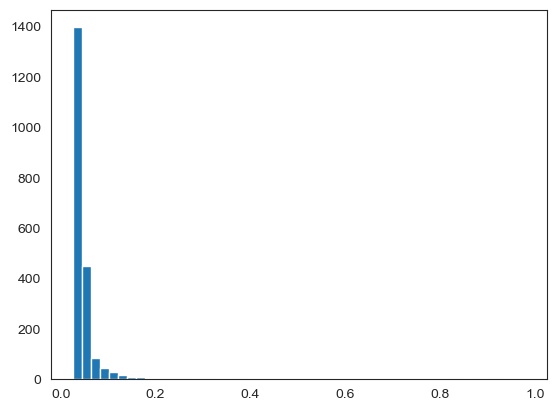

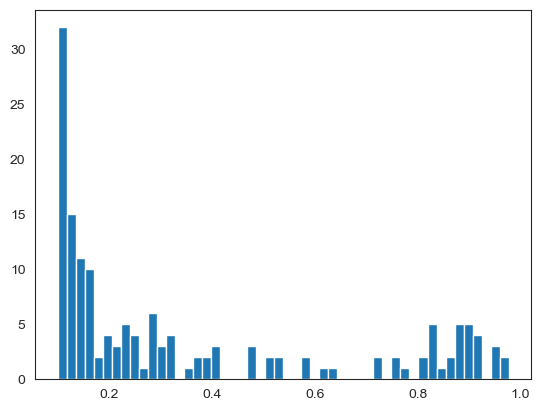

In [89]:
# Checking confidence distribution of predictions on the earthquake samples

peaks = []
peaks_above_01 = []

for ind in rows_w_eqs:
    peak = max(realtest_predictions[ind,:])
    peaks.append(peak)
    if peak >= 0.1:
        peaks_above_01.append(peak)
    
print(len(peaks))
print(len(peaks_above_01))

plt.hist(peaks, bins = 50)
plt.show()

plt.hist(peaks_above_01, bins = 50)
plt.show();